In [261]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools
from scipy.stats import norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import norm,skew
from matplotlib.pyplot import figure
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, log_loss
from sklearn import preprocessing

In [262]:
train_df=pd.read_csv(r"C:\Users\tan_k\Desktop\forest_kaggle\train.csv")
test_df=pd.read_csv(r"C:\Users\tan_k\Desktop\forest_kaggle\test.csv")

In [263]:
train_df.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5


In [264]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

# copied from https://www.kaggle.com/rinnqd/reduce-memory-usage

In [265]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

Memory usage after optimization is: 0.95 MB
Decreased by 85.3%
Memory usage after optimization is: 36.16 MB
Decreased by 84.8%


In [266]:
unique_values_dict = {}
for col in train_df.columns:
    if col not in ["Slope","Cover_Type","Id", "Elevation", "Aspect", "Horizontal_Distance_To_Hydrology", "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways", "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm","Horizontal_Distance_To_Fire_Points","Wilderness_Area1","Wilderness_Area2","Wilderness_Area3","Wilderness_Area4"]:
        unique_value = str(np.sort(train_df[col].unique()).tolist())
        tlist = unique_values_dict.get(unique_value, [])
        tlist.append(col)
        unique_values_dict[unique_value] = tlist[:]
for unique_val, columns in unique_values_dict.items():
    print("Columns containing the unique values : ",unique_val)
    print(columns)
    print("--------------------------------------------------")

Columns containing the unique values :  [0, 1]
['Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']
--------------------------------------------------
Columns containing the unique values :  [0]
['Soil_Type7', 'Soil_Type15']
--------------------------------------------------


In [267]:
train_df=train_df.drop(columns=['Soil_Type7','Soil_Type15','Id'])
test_df=test_df.drop(columns=['Soil_Type7','Soil_Type15','Id'])      


In [268]:
train_df.isna().sum()
test_df.isna().sum()
#all entries are filled

Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area1                      0
Wilderness_Area2                      0
Wilderness_Area3                      0
Wilderness_Area4                      0
Soil_Type1                            0
Soil_Type2                            0
Soil_Type3                            0
Soil_Type4                            0
Soil_Type5                            0
Soil_Type6                            0
Soil_Type8                            0
Soil_Type9                            0
Soil_Type10                           0
Soil_Type11                           0
Soil_Type12                           0


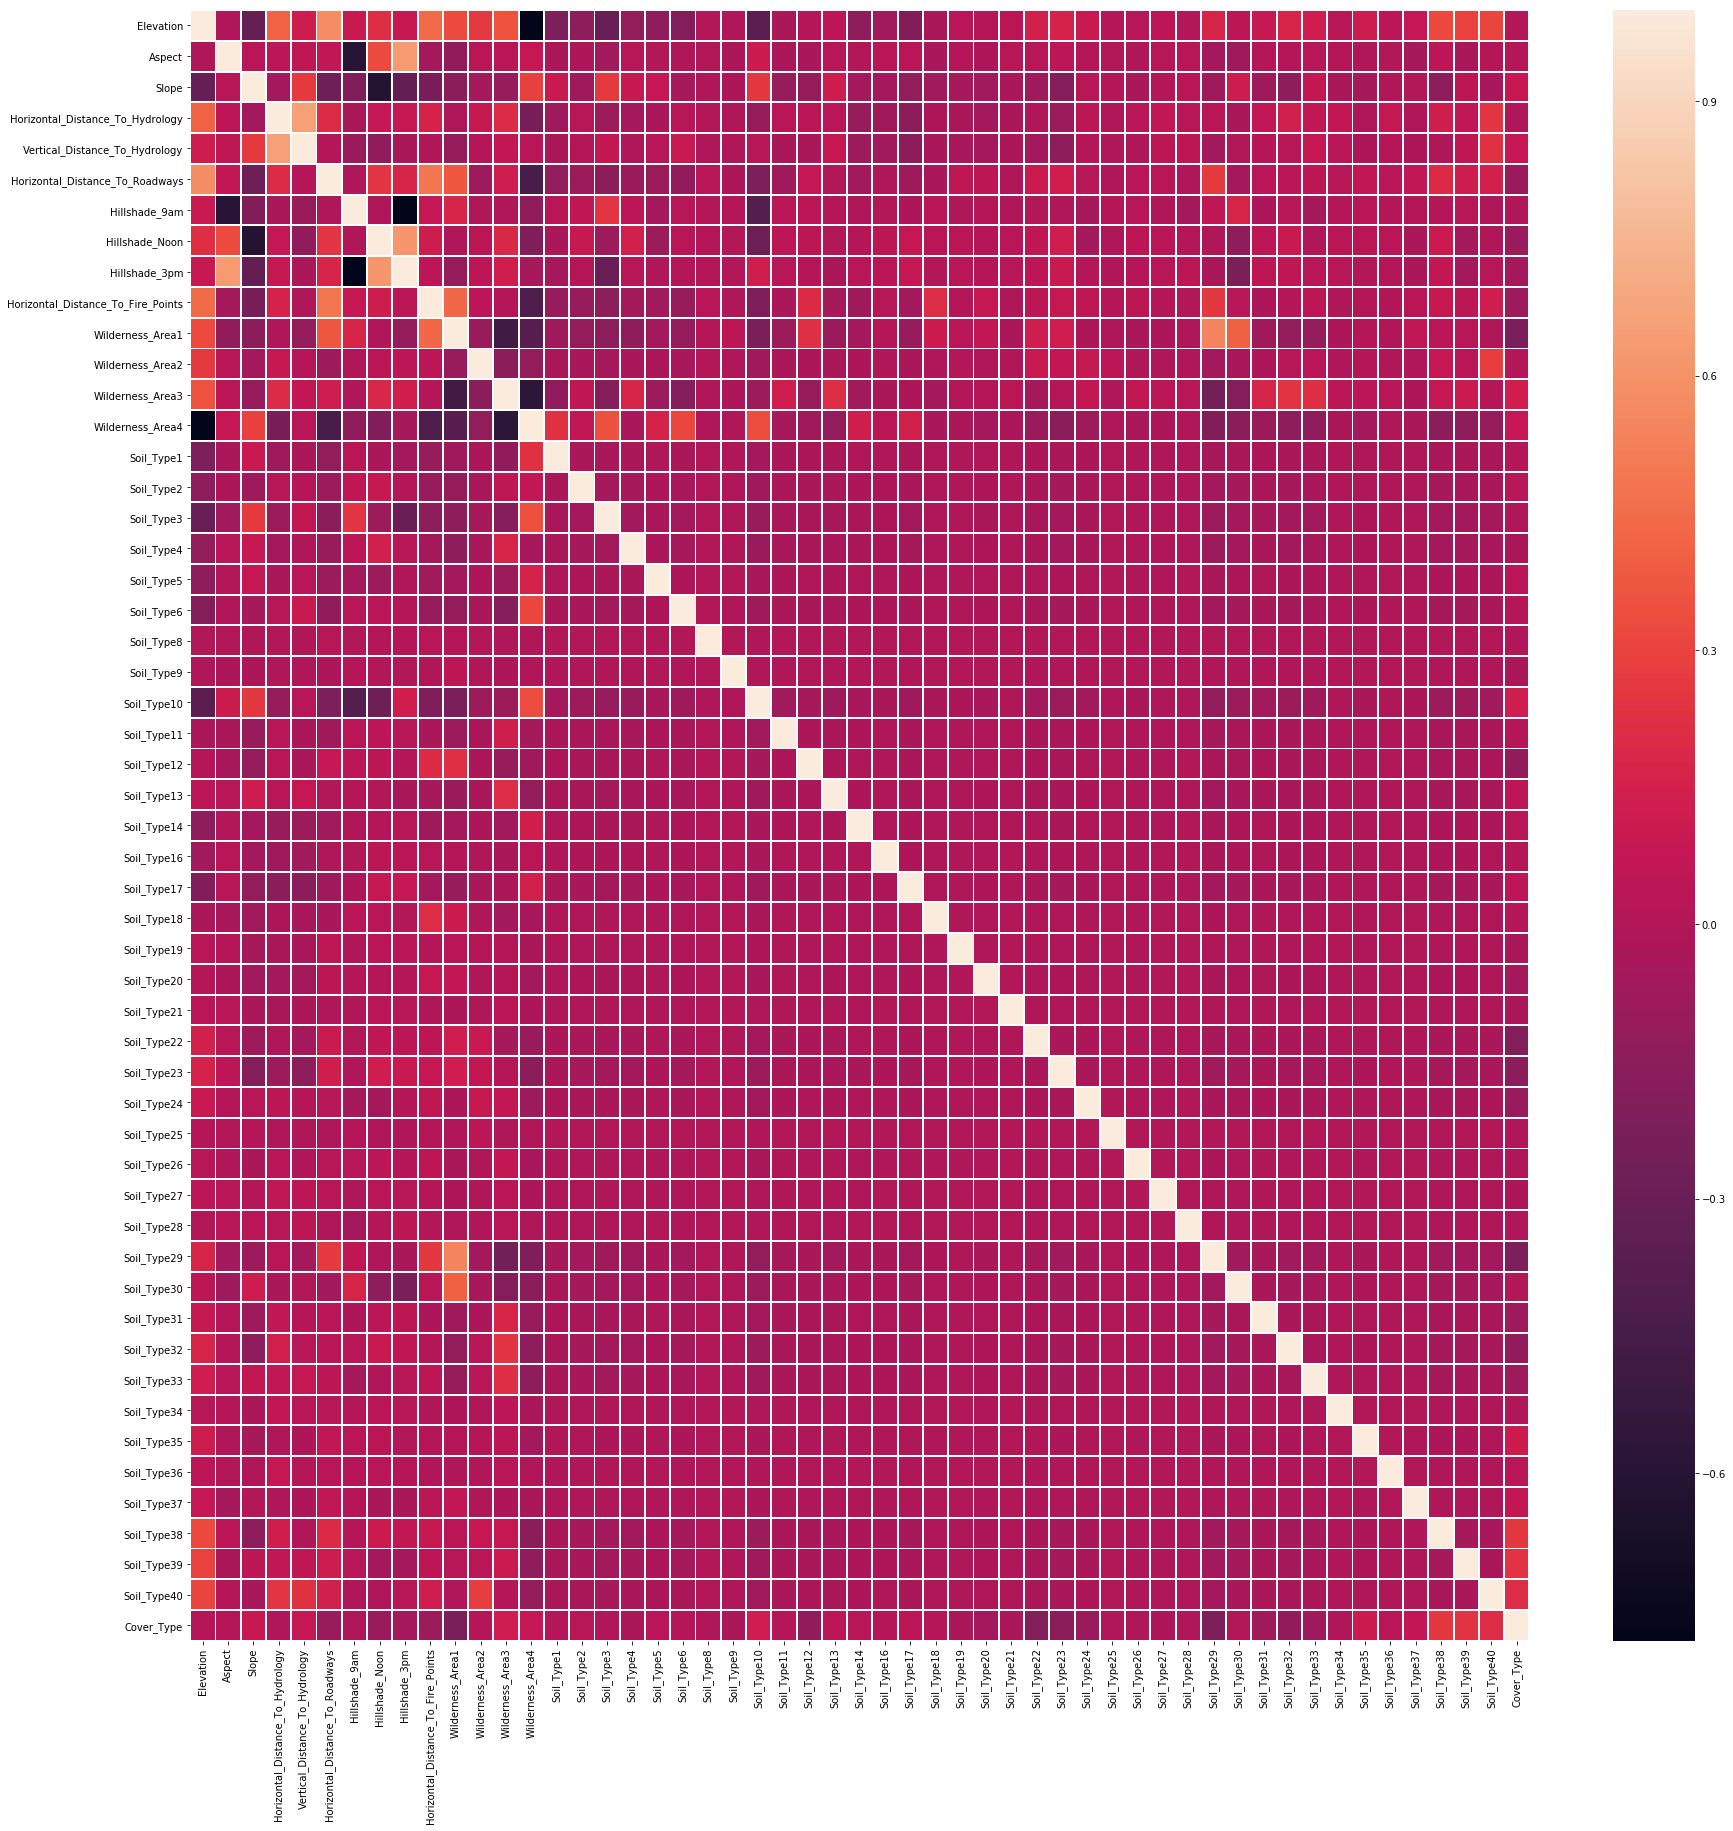

In [269]:
train_df.corr()
corrMatrix = train_df.corr()
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(corrMatrix,annot=False, linewidths =0.9, ax =ax)

In [270]:
threshold = 0.5

corr_list = []

#first 10 features
for i in range(0,10): 
    for j in range(i+1,10): 
        if (corrMatrix.iloc[i,j] >= threshold and corrMatrix.iloc[i,j] < 1) or (corrMatrix.iloc[i,j] < 0 and corrMatrix.iloc[i,j] <= -threshold):
            corr_list.append([corrMatrix.iloc[i,j],i,j]) 

       


for v,i,j in corr_list:
    print ("%s and %s = %.2f" % (train_df.columns[i],train_df.columns[j],v))


Elevation and Horizontal_Distance_To_Roadways = 0.58
Aspect and Hillshade_9am = -0.59
Aspect and Hillshade_3pm = 0.64
Slope and Hillshade_Noon = -0.61
Horizontal_Distance_To_Hydrology and Vertical_Distance_To_Hydrology = 0.65
Hillshade_9am and Hillshade_3pm = -0.78
Hillshade_Noon and Hillshade_3pm = 0.61


1. there is no correlation between the features and cover_type
2. Intuitively it makes sense to have hillshade_9am and 3pm to be negatively correlated, theres only one sun
3. 

Text(0.5, 1.0, 'Distribution of Cover_type with elevation')

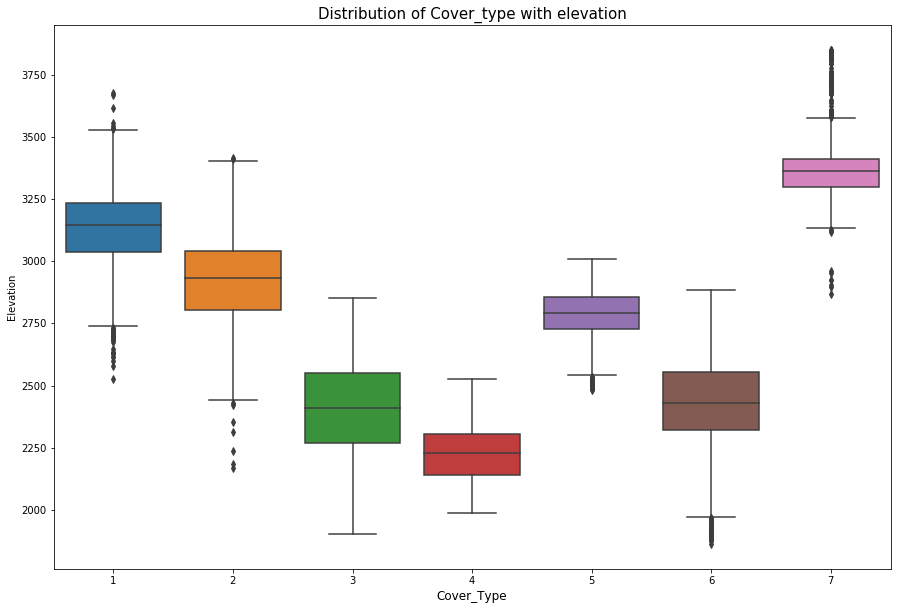

In [271]:
plt.figure(figsize=(15,10))
sns.boxplot(x='Cover_Type', y='Elevation', data=train_df)
plt.ylabel("Elevation")
plt.xlabel("Cover_Type", fontsize=12)
plt.title("Distribution of Cover_type with elevation", fontsize=15)

Text(0.5, 1.0, 'Distribution of Cover_type with Aspect')

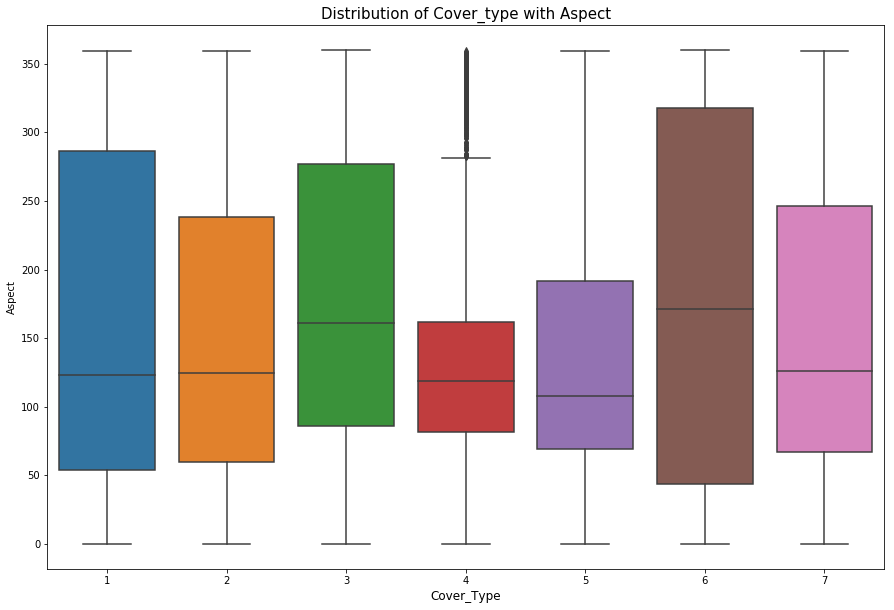

In [272]:
plt.figure(figsize=(15,10))
sns.boxplot(x='Cover_Type', y='Aspect', data=train_df)
plt.ylabel("Aspect")
plt.xlabel("Cover_Type", fontsize=12)
plt.title("Distribution of Cover_type with Aspect", fontsize=15)

Text(0.5, 1.0, 'Distribution of Cover_type with Slope')

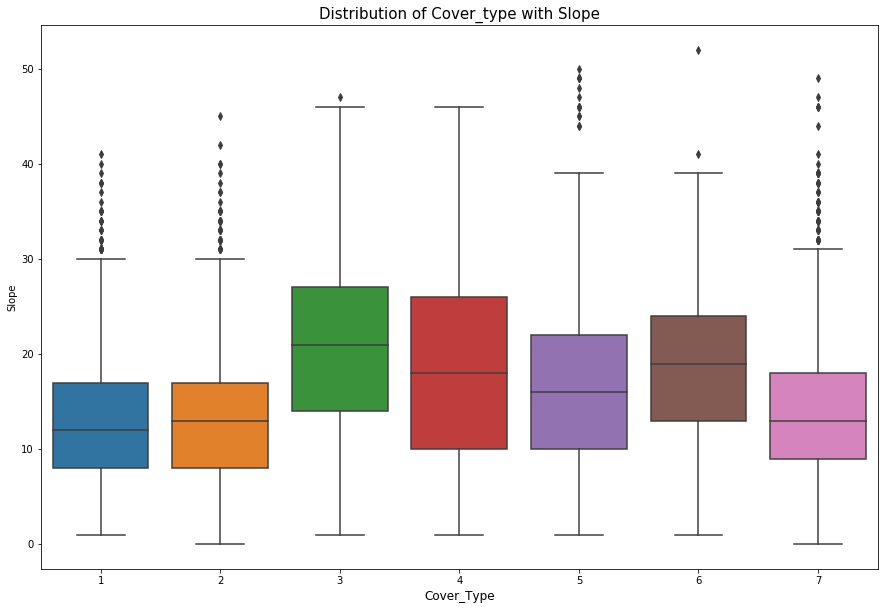

In [273]:
plt.figure(figsize=(15,10))
sns.boxplot(x='Cover_Type', y='Slope', data=train_df)
plt.ylabel("Slope")
plt.xlabel("Cover_Type", fontsize=12)
plt.title("Distribution of Cover_type with Slope", fontsize=15)

Text(0.5, 1.0, 'Distribution of Cover_type with Horizontal_Distance_To_Hydrology')

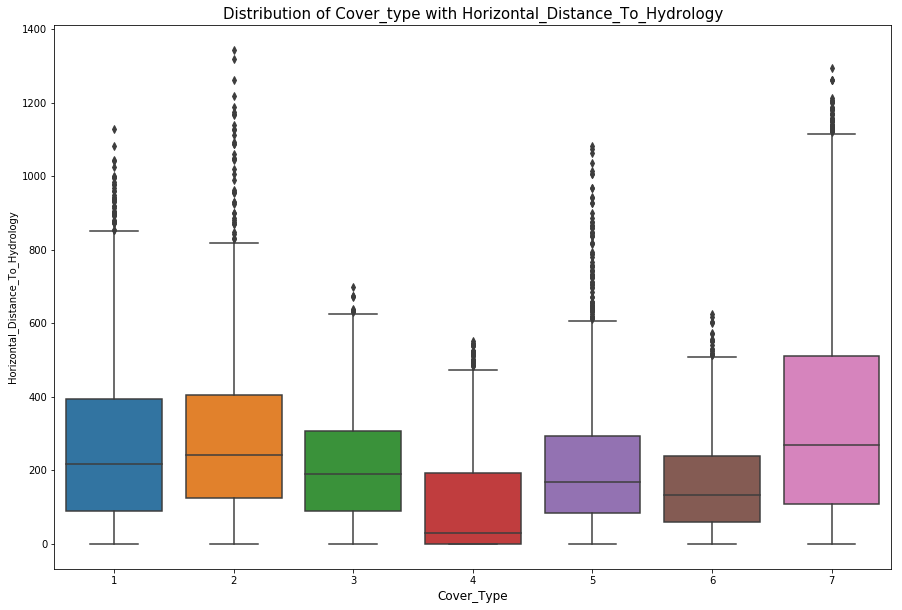

In [314]:
plt.figure(figsize=(15,10))
sns.boxplot(x='Cover_Type', y='Horizontal_Distance_To_Hydrology', data=train_df)
plt.ylabel("Horizontal_Distance_To_Hydrology")
plt.xlabel("Cover_Type", fontsize=12)
plt.title("Distribution of Cover_type with Horizontal_Distance_To_Hydrology", fontsize=15)

Text(0.5, 1.0, 'Distribution of Cover_type with Horizontal_Distance_To_Roadways')

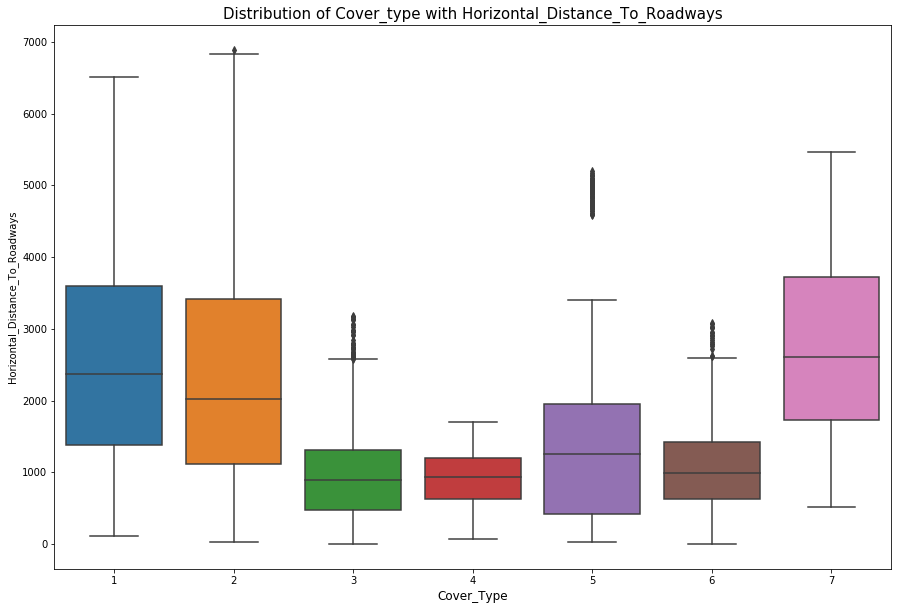

In [275]:
plt.figure(figsize=(15,10))
sns.boxplot(x='Cover_Type', y='Horizontal_Distance_To_Roadways', data=train_df)
plt.ylabel("Horizontal_Distance_To_Roadways")
plt.xlabel("Cover_Type", fontsize=12)
plt.title("Distribution of Cover_type with Horizontal_Distance_To_Roadways", fontsize=15)

Text(0.5, 1.0, 'Distribution of Cover_type with Hillshade_9am')

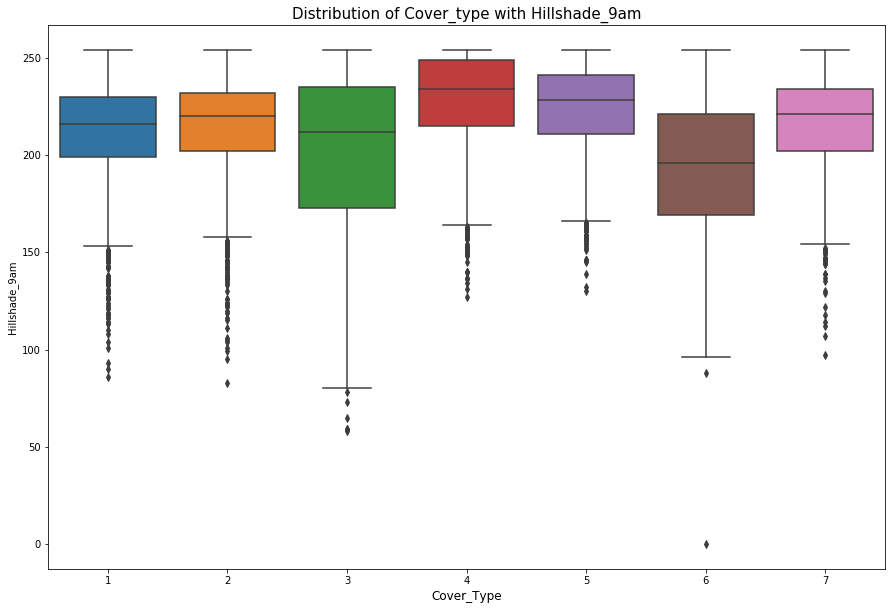

In [310]:
plt.figure(figsize=(15,10))
sns.boxplot(x='Cover_Type', y='Hillshade_9am', data=train_df)
plt.ylabel("Hillshade_9am")
plt.xlabel("Cover_Type", fontsize=12)
plt.title("Distribution of Cover_type with Hillshade_9am", fontsize=15)

Text(0.5, 1.0, 'Distribution of Cover_type with Hillshade_Noon')

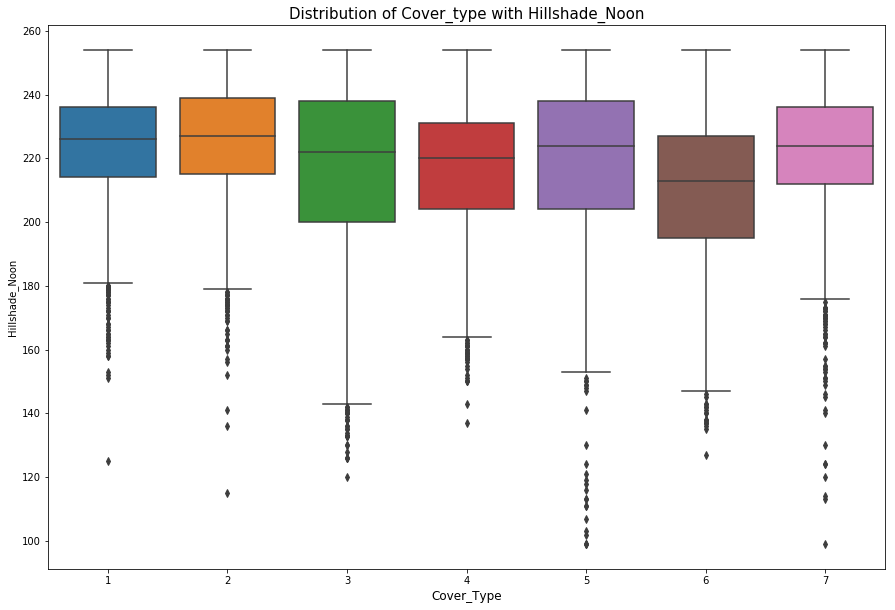

In [311]:
plt.figure(figsize=(15,10))
sns.boxplot(x='Cover_Type', y='Hillshade_Noon', data=train_df)
plt.ylabel("Hillshade_Noon")
plt.xlabel("Cover_Type", fontsize=12)
plt.title("Distribution of Cover_type with Hillshade_Noon", fontsize=15)

Text(0.5, 1.0, 'Distribution of Cover_type with Hillshade_3pm')

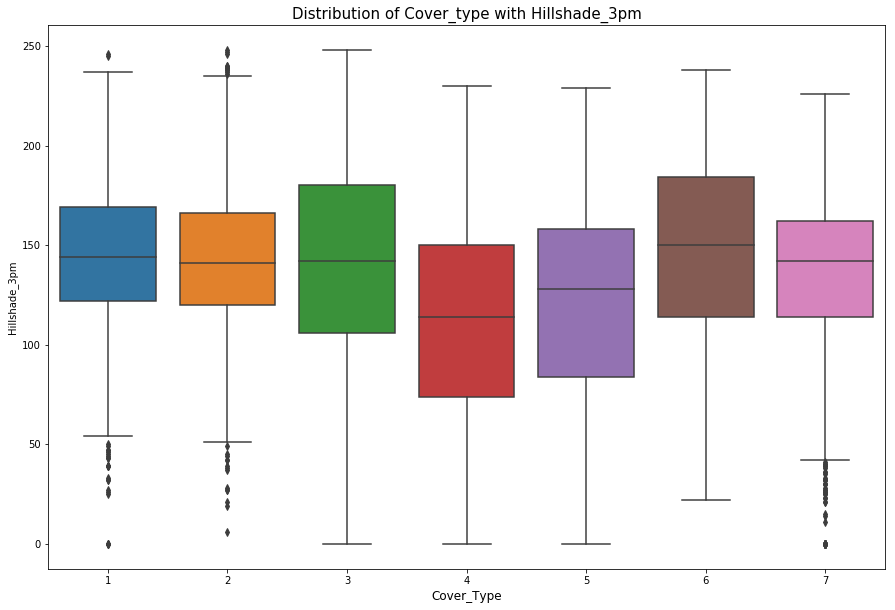

In [315]:
plt.figure(figsize=(15,10))
sns.boxplot(x='Cover_Type', y='Hillshade_3pm', data=train_df)
plt.ylabel("Hillshade_3pm")
plt.xlabel("Cover_Type", fontsize=12)
plt.title("Distribution of Cover_type with Hillshade_3pm", fontsize=15)

Text(0.5, 1.0, 'Distribution of Cover_type with Horizontal_Distance_To_Fire_Points')

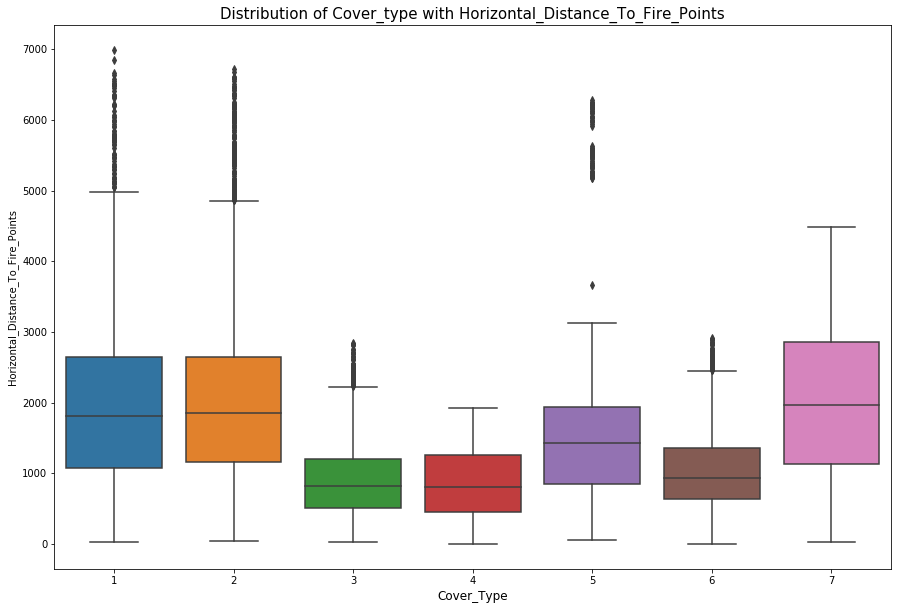

In [316]:
plt.figure(figsize=(15,10))
sns.boxplot(x='Cover_Type', y='Horizontal_Distance_To_Fire_Points', data=train_df)
plt.ylabel("Horizontal_Distance_To_Fire_Points")
plt.xlabel("Cover_Type", fontsize=12)
plt.title("Distribution of Cover_type with Horizontal_Distance_To_Fire_Points", fontsize=15)

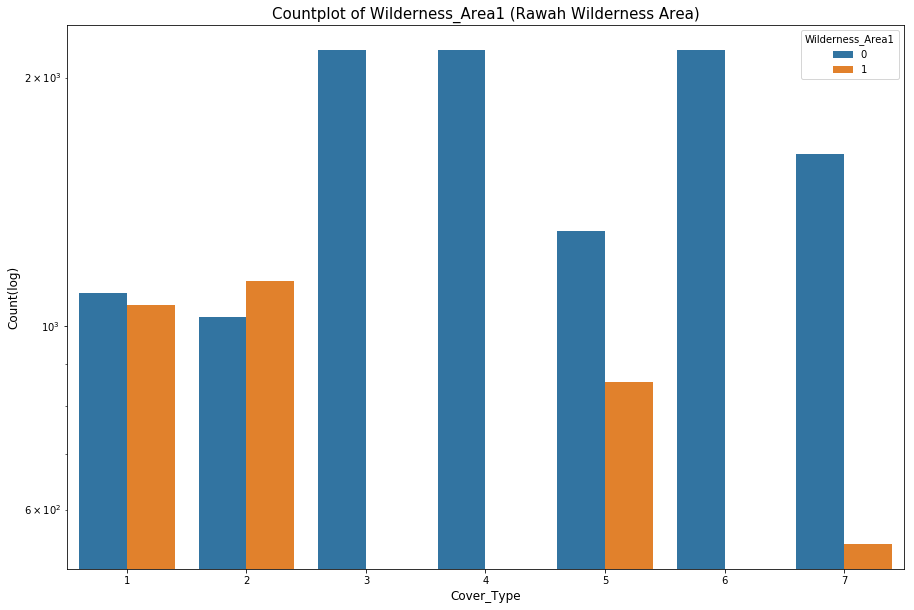

In [280]:
plt.figure(figsize=(15,10))
sns.countplot('Cover_Type', hue='Wilderness_Area1', data=train_df)
plt.xlabel("Cover_Type", fontsize=12)
plt.ylabel("Count(log)", fontsize=12)
plt.yscale('log')
plt.title("Countplot of Wilderness_Area1 (Rawah Wilderness Area)", fontsize=15)
plt.show()

There will not be cover type 3,4 and 6 present in Rawah wilderness Area

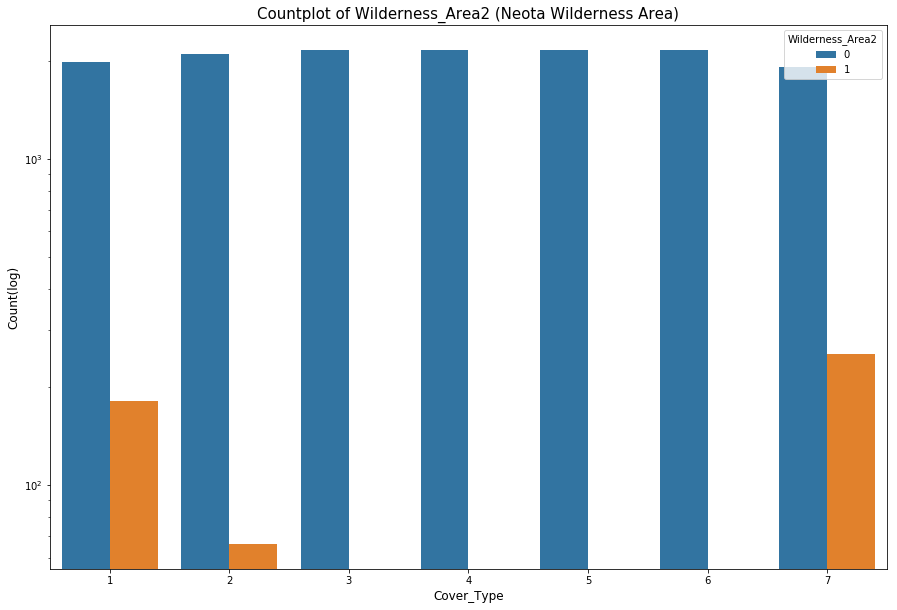

In [281]:
plt.figure(figsize=(15,10))
sns.countplot('Cover_Type', hue='Wilderness_Area2', data=train_df)
plt.xlabel("Cover_Type", fontsize=12)
plt.ylabel("Count(log)", fontsize=12)
plt.yscale('log')
plt.title("Countplot of Wilderness_Area2 (Neota Wilderness Area)", fontsize=15)
plt.show()

There will not be cover type 3,4,5 and 6 present in Neota wilderness Area


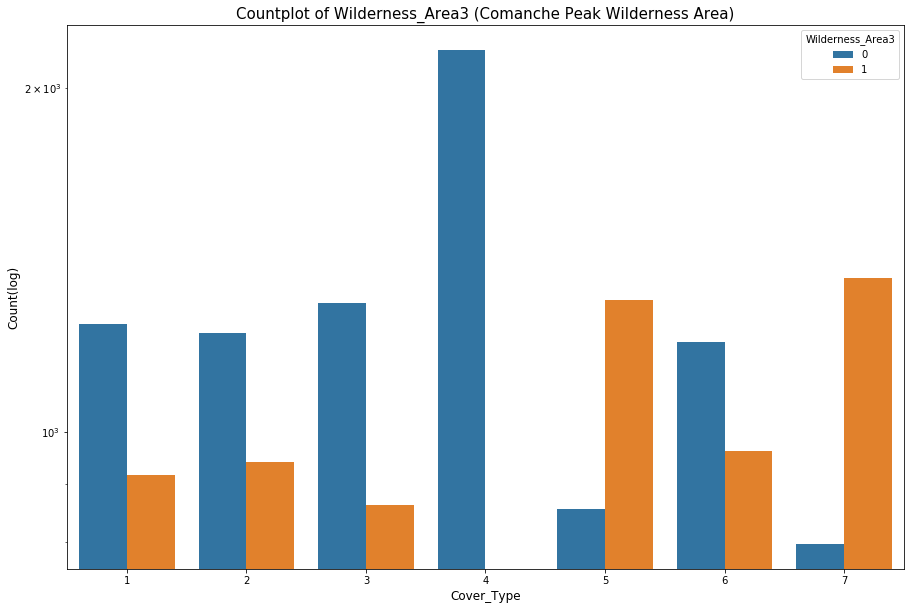

In [282]:
plt.figure(figsize=(15,10))
sns.countplot('Cover_Type', hue='Wilderness_Area3', data=train_df)
plt.xlabel("Cover_Type", fontsize=12)
plt.ylabel("Count(log)", fontsize=12)
plt.yscale('log')
plt.title("Countplot of Wilderness_Area3 (Comanche Peak Wilderness Area)", fontsize=15)
plt.show()

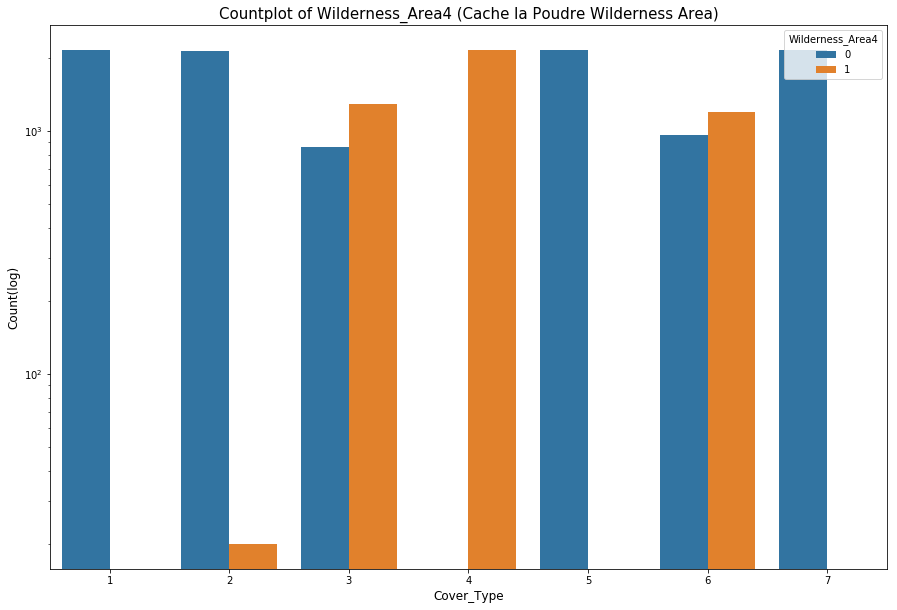

In [283]:
plt.figure(figsize=(15,10))
sns.countplot('Cover_Type', hue='Wilderness_Area4', data=train_df)
plt.xlabel("Cover_Type", fontsize=12)
plt.ylabel("Count(log)", fontsize=12)
plt.yscale('log')
plt.title("Countplot of Wilderness_Area4 (Cache la Poudre Wilderness Area)", fontsize=15)
plt.show()

There is no cover 1 and 7 type in Cache La Poudre Wilderness Area)

#creating map using geo 
dat
type 1 - 40.7694° N, 105.9895° W
type 2 - 40.3122  N  105.4957  W
tpye 3 - 40.5844  N, 105.6691  W
type 4 - 40.6600° N, 105.4494° W
d = {'Lat.': [40.7694, 40.3122, 40.5844, 40.6600], 'Long.': [3, 4]}
df = pd.DataFrame(data=d)
df

# Data interation visualisation

In [284]:
corr_list

[[0.5786589907340067, 0, 5],
 [-0.5939974281313112, 1, 6],
 [0.635022364019874, 1, 8],
 [-0.6126128724172692, 2, 7],
 [0.6521424712357364, 3, 4],
 [-0.779964742447544, 6, 8],
 [0.6145263872475779, 7, 8]]

C:\Users\tan_k\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


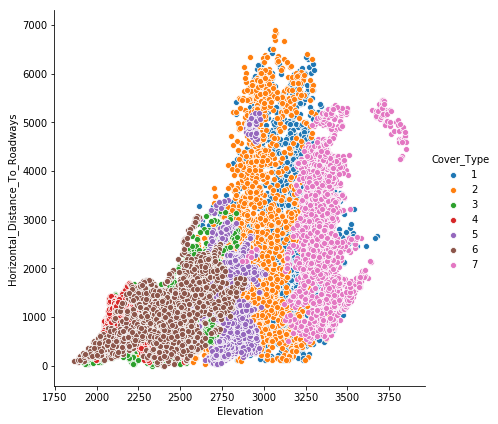

C:\Users\tan_k\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


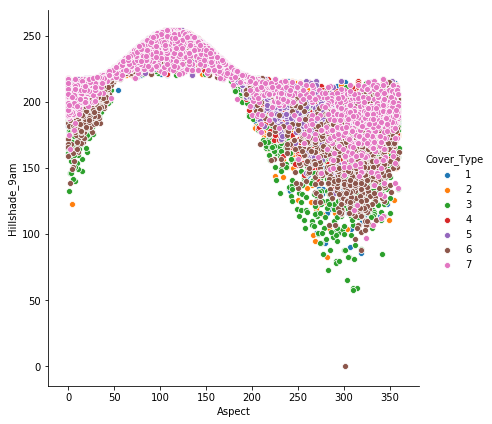

C:\Users\tan_k\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


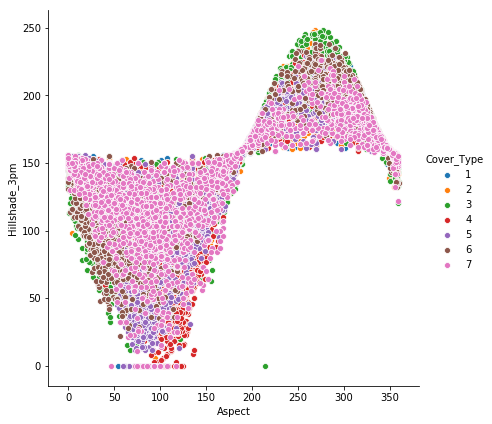

C:\Users\tan_k\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


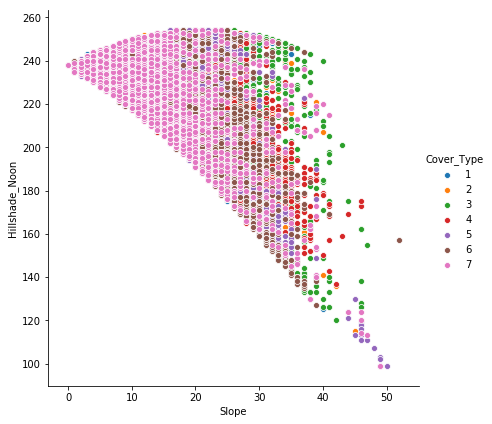

C:\Users\tan_k\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


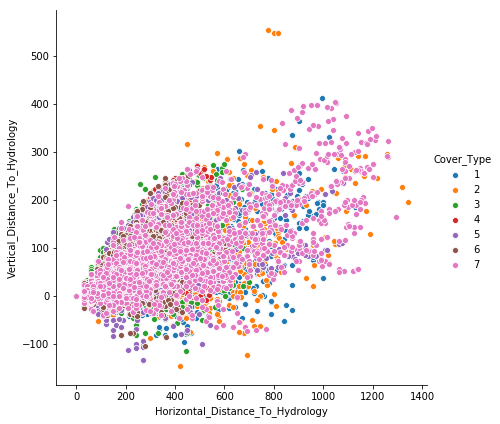

C:\Users\tan_k\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


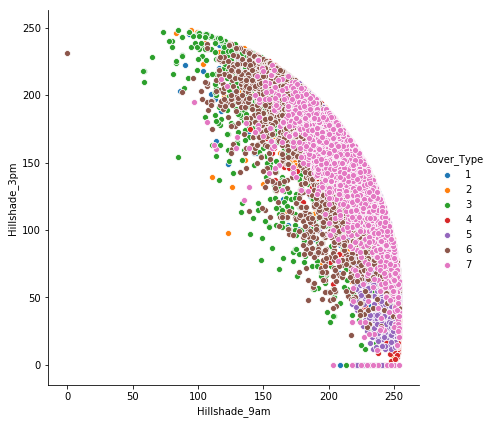

C:\Users\tan_k\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


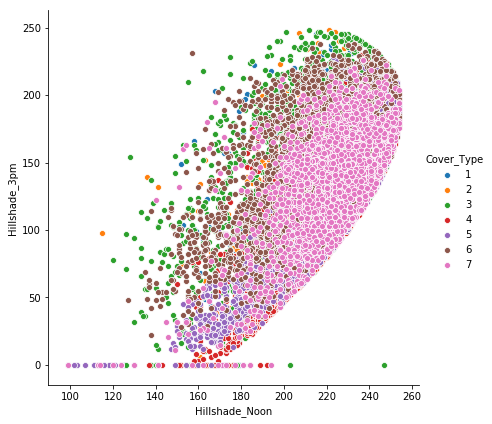

In [285]:
import seaborn as sns
import matplotlib.pyplot as plt


for v,i,j in corr_list:
    sns.pairplot(train_df, hue="Cover_Type", size=6, x_vars=train_df.columns[i],y_vars=train_df.columns[j] )
    plt.show()

# MinMax Scaler on training data and validation data

In [286]:
from sklearn.model_selection import train_test_split
Y=train_df.filter(['Cover_Type'])
X_orig=train_df.drop(columns='Cover_Type')
val_size=0.2


X_train, X_val, Y_train, Y_val = train_test_split(X_orig, Y, test_size=val_size, random_state=500)

In [287]:
test_df

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,2680,354,14,0,0,2684,196,214,156,6645,...,0,0,0,0,0,0,0,0,0,0
1,2683,0,13,0,0,2654,201,216,152,6675,...,0,0,0,0,0,0,0,0,0,0
2,2713,16,15,0,0,2980,206,208,137,6344,...,0,0,0,0,0,0,0,0,0,0
3,2709,24,17,0,0,2950,208,201,125,6374,...,0,0,0,0,0,0,0,0,0,0
4,2706,29,19,0,0,2920,210,195,115,6404,...,0,0,0,0,0,0,0,0,0,0
5,2699,21,18,30,3,2890,206,200,127,6434,...,0,0,0,0,0,0,0,0,0,0
6,2699,15,17,30,6,2860,202,202,133,6464,...,0,0,0,0,0,0,0,0,0,0
7,2696,10,16,30,6,2830,202,207,140,6494,...,0,0,0,0,0,0,0,0,0,0
8,2696,17,13,30,6,2770,208,211,138,6553,...,0,0,0,0,0,0,0,0,0,0
9,2693,14,15,30,7,2741,205,209,138,6583,...,0,0,0,0,0,0,0,0,0,0


In [288]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
scaler = preprocessing.RobustScaler()
X_train_temp = MinMaxScaler().fit_transform(X_train.iloc[:,0:10])
X_val_temp= MinMaxScaler().fit_transform(X_val.iloc[:,0:10])


X_con=np.concatenate((X_train_temp,X_train.iloc[:,10:]),axis=1)
X_val_con=np.concatenate((X_val_temp,X_val.iloc[:,10:]),axis=1)
print(X_con.shape,X_val_con.shape)

(12096, 52) (3024, 52)


C:\Users\tan_k\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int8, int16 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\tan_k\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int8, int16 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [289]:
X_test_temp.shape

(565892, 10)

In [291]:
from sklearn import preprocessing
X_test_temp= MinMaxScaler().fit_transform(test_df.iloc[:,0:10])
#X_test_temp = MinMaxScaler().transform(test_df.iloc[:,0:10])
X_test=np.concatenate((X_test_temp,test_df.iloc[:,10:]),axis=1)

C:\Users\tan_k\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int8, int16 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [292]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

model = RandomForestClassifier(n_estimators=100,n_jobs=-1, bootstrap=True, max_features ='sqrt')

pred_val=model.fit(X_con,Y_train)

C:\Users\tan_k\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


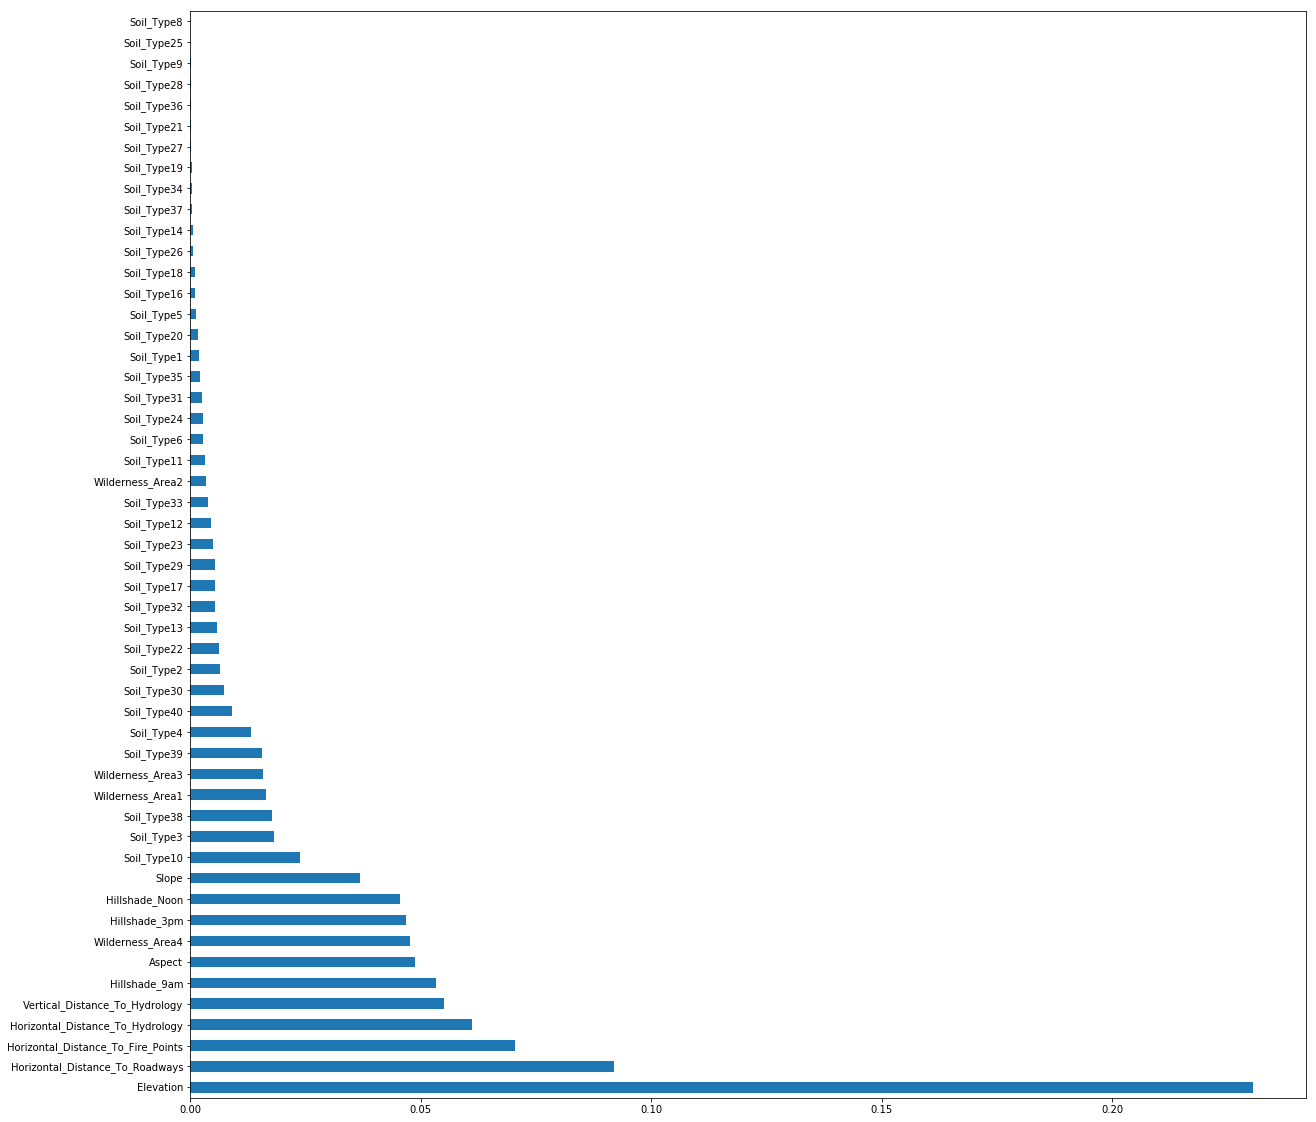

In [293]:
plt.figure(figsize=(20,20))
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(52).plot(kind='barh')

In [294]:
for feature in zip(X_train.columns,model.feature_importances_):
    print(feature)

('Elevation', 0.23051945511388097)
('Aspect', 0.04882772919755283)
('Slope', 0.036839923853045436)
('Horizontal_Distance_To_Hydrology', 0.06116513964102385)
('Vertical_Distance_To_Hydrology', 0.055007719260414485)
('Horizontal_Distance_To_Roadways', 0.0919214442517991)
('Hillshade_9am', 0.05338900674335928)
('Hillshade_Noon', 0.04549653929714153)
('Hillshade_3pm', 0.046763640847003546)
('Horizontal_Distance_To_Fire_Points', 0.0704995728767424)
('Wilderness_Area1', 0.01643821586628874)
('Wilderness_Area2', 0.0034746122474814275)
('Wilderness_Area3', 0.015885777531733866)
('Wilderness_Area4', 0.047631246585072666)
('Soil_Type1', 0.0018636157692720568)
('Soil_Type2', 0.006424744920783598)
('Soil_Type3', 0.018282479025161138)
('Soil_Type4', 0.013233462510589378)
('Soil_Type5', 0.0012715313933720968)
('Soil_Type6', 0.00272033298682544)
('Soil_Type8', 7.3014154156118125e-06)
('Soil_Type9', 8.654459297840165e-05)
('Soil_Type10', 0.023870495457042805)
('Soil_Type11', 0.003274246758865689)
('So

In [295]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', normalize=False, cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fmt = '.2f' if normalize else 'd'

    fig, ax = plt.subplots(figsize=(15, 10))
    ax.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size=15)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = (cm.max()+cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', size=12)
    plt.xlabel('Predicted label', size=12)

In [296]:
pred_val=model.predict(X_val_con)

In [297]:
print(Y_val["Cover_Type"].values.size)
pred_val.shape

3024


(3024,)

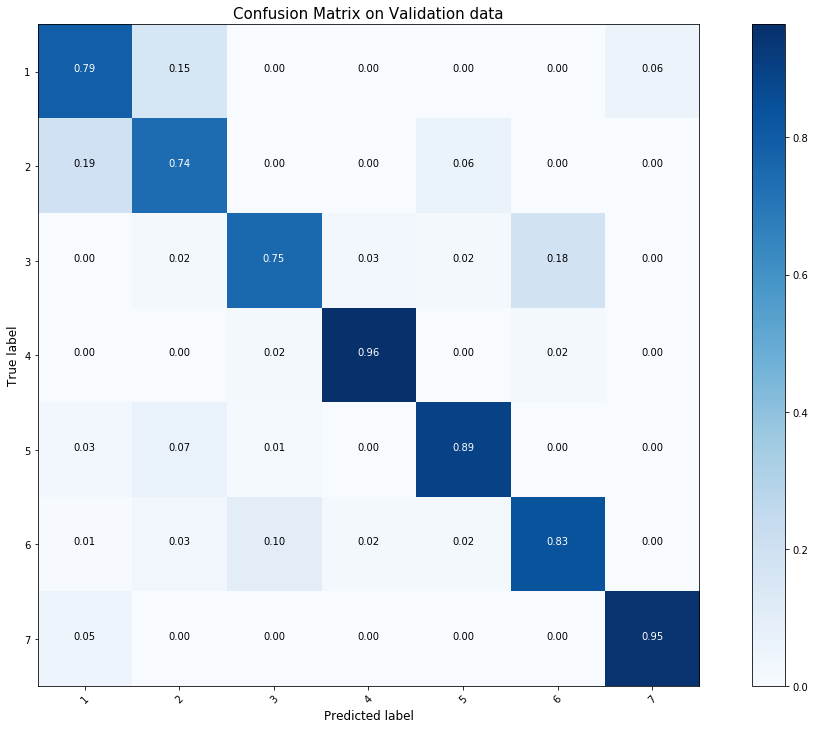

In [298]:
from sklearn.metrics import confusion_matrix, log_loss
conf_mat_val = confusion_matrix(pred_val, Y_val["Cover_Type"].values)
plot_confusion_matrix(conf_mat_val,["1","2","3","4","5","6","7"], title='Confusion Matrix on Validation data', normalize=True)

In [299]:
from sklearn.metrics import accuracy_score
accuracy_score(pred_val, Y_val["Cover_Type"].values)

0.8462301587301587

In [300]:
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(model, threshold=0.025)
sfm_val=sfm.fit(X_con,Y_train)

C:\Users\tan_k\Anaconda3\lib\site-packages\sklearn\feature_selection\from_model.py:197: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


In [301]:
for feature_list_index in sfm.get_support(indices=True):
    print(X_val.columns[feature_list_index])

Elevation
Aspect
Slope
Horizontal_Distance_To_Hydrology
Vertical_Distance_To_Hydrology
Horizontal_Distance_To_Roadways
Hillshade_9am
Hillshade_Noon
Hillshade_3pm
Horizontal_Distance_To_Fire_Points
Wilderness_Area4


In [302]:
X_important_train = sfm.transform(X_con)
X_important_test = sfm.transform(X_val)

In [ ]:
#clf_impt=model.fit(X_important_train,Y_train)

In [303]:
y_impt_pred = clf_impt.predict(X_important_test)
accuracy_score(Y_val["Cover_Type"].values,y_impt_pred)

0.14682539682539683

In [304]:
X_val_con.shape

(3024, 52)

In [305]:
X_test.shape

(565892, 52)

In [307]:
print('Predict Submission')
submission = pd.read_excel(r'C:\Users\tan_k\Desktop\forest_kaggle\sampleSubmission.xlsx')
submission.iloc[:,1] = model.predict(X_test)
submission.to_csv("forest_submission.csv",index=False)

Predict Submission


In [308]:
submission.to_csv("forest_submission.csv",index=False)